###8.1 One-sample comparison
Stanardized difference scores(ie., "winter scores - summer scores")

The null hypothesis states that the mean of the diffence scores is equal to zero : H0 : u=0

The alternative hypothesis states that the mean is not equal to zero : H1 : u <> 0

Loading required package: rjags
Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs

Attaching package: 'R2jags'

The following object is masked from 'package:coda':

    traceplot

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 55

Initializing model



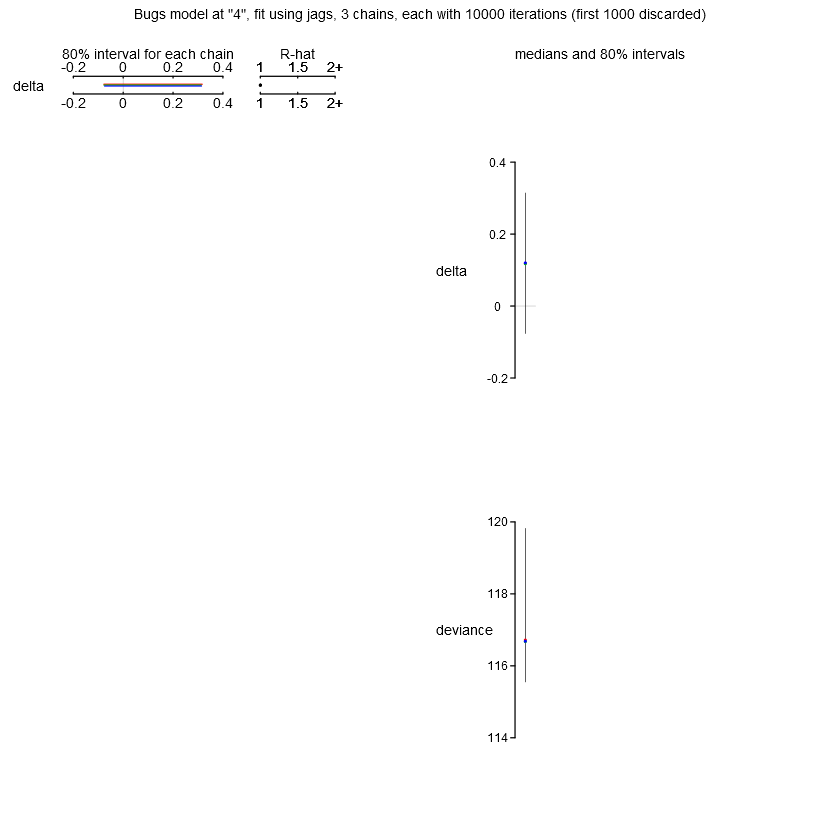

In [1]:
options(jupyter.plot_mimetypes = 'image/png')
# clears workspace:  
rm(list=ls()) 

#JARS
library(R2jags)

# Read data Dr. Smith
Winter = c(-0.05,0.41,0.17,-0.13,0.00,-0.05,0.00,0.17,0.29,0.04,0.21,0.08,0.37,0.17,0.08,-0.04,-0.04,0.04,-0.13,-0.12,0.04,0.21,0.17,
            0.17,0.17,0.33,0.04,0.04,0.04,0.00,0.21,0.13,0.25,-0.05,0.29,0.42,-0.05,0.12,0.04,0.25,0.12)

Summer = c(0.00,0.38,-0.12,0.12,0.25,0.12,0.13,0.37,0.00,0.50,0.00,0.00,-0.13,-0.37,-0.25,-0.12,0.50,0.25,0.13,0.25,0.25,0.38,0.25,0.12,
            0.00,0.00,0.00,0.00,0.25,0.13,-0.25,-0.38,-0.13,-0.25,0.00,0.00,-0.12,0.25,0.00,0.50,0.00)

x = Winter-Summer # allowed because it is a within-subjects design
x = x/sd(x)       # standardize

ndata = length(Winter) # number of subjects

data  = list("x", "ndata") # to be passed on to JAGS

# inital value
myinits <- list(
  list(delta = rnorm(1,0,3), sigmatmp = rnorm(1,0,1)),
  list(delta = rnorm(1,0,3), sigmatmp = rnorm(1,0,1)),
  list(delta = rnorm(1,0,3), sigmatmp = rnorm(1,0,1)))

# Parameters to be monitored
parameters = c("delta")

# 1. Model
# One-Sample Comparison of Means
modelString = "
model{
  # Data
  for (i in 1:ndata){
    x[i] ~ dnorm(mu,lambda)
  } 
  mu <- delta*sigma
  lambda <- pow(sigma,-2)
  # delta and sigma Come From (Half) Cauchy Distributions
  lambdadelta ~ dchisqr(1)
  delta ~ dnorm(0,lambdadelta)
  lambdasigma ~ dchisqr(1)
  sigmatmp ~ dnorm(0,lambdasigma)
  sigma <- abs(sigmatmp)
  # Sampling from Prior Distribution for Delta
  deltaprior ~ dnorm(0,lambdadeltaprior)
  lambdadeltaprior ~ dchisqr(1)
}"

# The following command calls JAGS with specific options.
# For a detailed description see the R2jags documentation.
samples = jags(data, inits=myinits, parameters, 
               model.file=textConnection(modelString),
               n.chains=3, n.iter=10000, n.burnin=1000, n.thin=1, DIC=T)
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.

plot(samples)

In [2]:
# Collect posterior samples across all chains:
delta.posterior = samples$BUGSoutput$sims.list$delta  

#============ BFs based on logspline fit ===========================
library(polspline) # this package can be installed from within R
fit.posterior = logspline(delta.posterior)

# 95% confidence interval:
x0 = qlogspline(0.025,fit.posterior)
x1 = qlogspline(0.975,fit.posterior)

posterior = dlogspline(0, fit.posterior) # this gives the pdf at point delta = 0
prior     = dcauchy(0)                   # height of order--restricted prior at delta = 0
BF01      = posterior/prior
BF01

[1] 6.018839

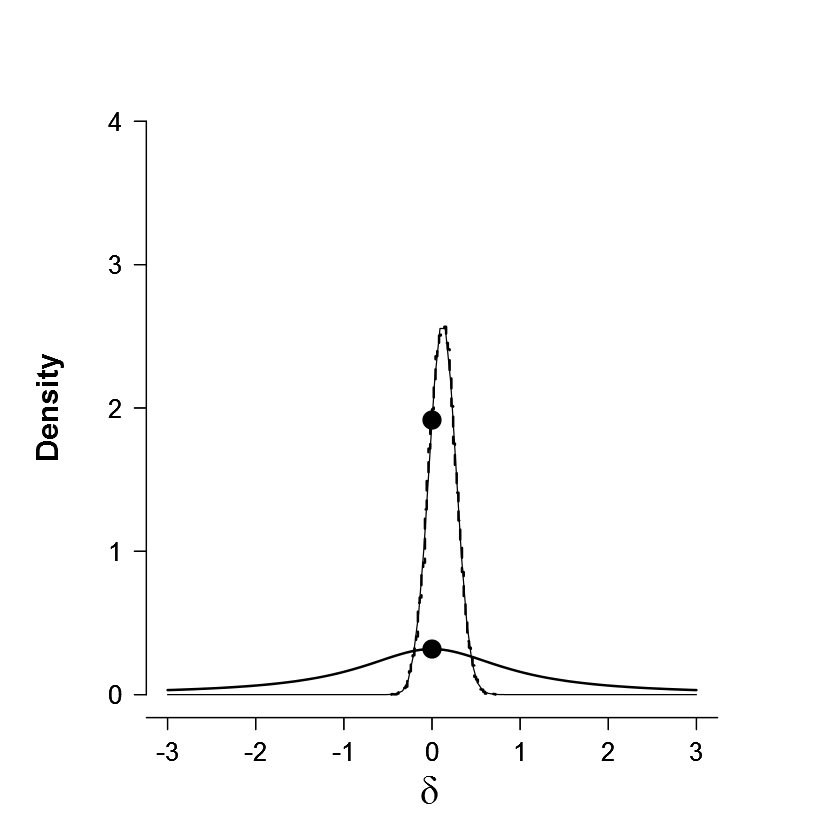

In [8]:
#============ Plot Prior and Posterior  ===========================
par(cex.main = 1.5, mar = c(5, 6, 4, 5) + 0.1, mgp = c(3.5, 1, 0), cex.lab = 1.5,
    font.lab = 2, cex.axis = 1.3, bty = "n", las=1)
xlow  = -3
xhigh = 3
yhigh = 4
Nbreaks = 80
y       = hist(delta.posterior, Nbreaks, plot=F)
plot(c(y$breaks, max(y$breaks)), c(0,y$density,0), type="S", lwd=2, lty=2,
     xlim=c(xlow,xhigh), ylim=c(0,yhigh), xlab=" ", ylab="Density", axes=F) 
axis(1, at = c(-4,-3,-2,-1,0,1,2,3,4), lab=c("-4","-3","-2","-1","0", "1", "2", "3", "4"))
axis(2)
mtext(expression(delta), side=1, line = 2.8, cex=2)
#now bring in log spline density estimation:
par(new=T)
plot(fit.posterior, ylim=c(0,yhigh), xlim=c(xlow,xhigh), lty=1, lwd=1, axes=F)
points(0, dlogspline(0, fit.posterior),pch=19, cex=2)
# plot the prior:
par(new=T)
plot ( function( x ) dcauchy( x, 0, 1 ), xlow, xhigh, ylim=c(0,yhigh), xlim=c(xlow,xhigh), lwd=2, lty=1, ylab=" ", xlab = " ", axes=F) 
axis(1, at = c(-4,-3,-2,-1,0,1,2,3,4), lab=c("-4","-3","-2","-1","0", "1", "2", "3", "4"))
axis(2)
points(0, dcauchy(0), pch=19, cex=2)